<a href="https://colab.research.google.com/github/kela2023/aah/blob/main/Classification_image_qui_passe_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# les bibliotheques utiles
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import cv2
import requests
import matplotlib.image as mpimg
import sys
import datetime

In [2]:
import pathlib
data_dir = tf.keras.utils.get_file(
    "test.zip",
    "https://github.com/kela2023/train_images/raw/main/test.zip?raw=true",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/test')
print(data_dir)
print(os.path.abspath(data_dir))




6200472/6200472 [==============================] - 0s 0us/step
/content/datasets/test
/content/datasets/test


In [3]:

image_count = len(list(data_dir.glob('*/*')))
print(image_count)

32


In [4]:
batch_size = 3
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 32 files belonging to 2 classes.
Using 26 files for training.
Found 32 files belonging to 2 classes.
Using 6 files for validation.
['rihanna', 'will']


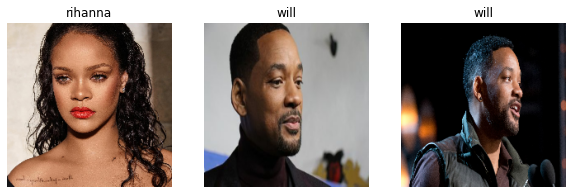

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(3, 200, 200, 3)
(3,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0009705825 1.0


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [14]:
epochs=10
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 1.7854 - accuracy: 0.4615 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 3s 322ms/step - loss: 0.6458 - accuracy: 0.6154 - val_loss: 0.6428 - val_accuracy: 0.6667
Epoch 3/10
9/9 [==============================] - 2s 192ms/step - loss: 0.5048 - accuracy: 0.8077 - val_loss: 0.6089 - val_accuracy: 0.6667
Epoch 4/10
9/9 [==============================] - 2s 199ms/step - loss: 0.2066 - accuracy: 0.9615 - val_loss: 0.5344 - val_accuracy: 0.6667
Epoch 5/10
9/9 [==============================] - 2s 199ms/step - loss: 0.0925 - accuracy: 0.9231 - val_loss: 0.8392 - val_accuracy: 0.6667
Epoch 6/10
9/9 [==============================] - 2s 199ms/step - loss: 0.0654 - accuracy: 0.9615 - val_loss: 1.1765 - val_accuracy: 0.6667
Epoch 7/10
9/9 [==============================] - 3s 317ms/step - loss: 0.0906 - accuracy: 0.9615 - val_loss: 0.7246 - val_accuracy: 0.6667
Epoch 8/10
9/9 [======

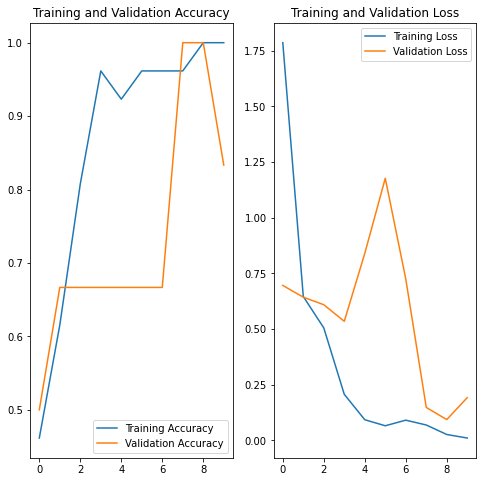

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

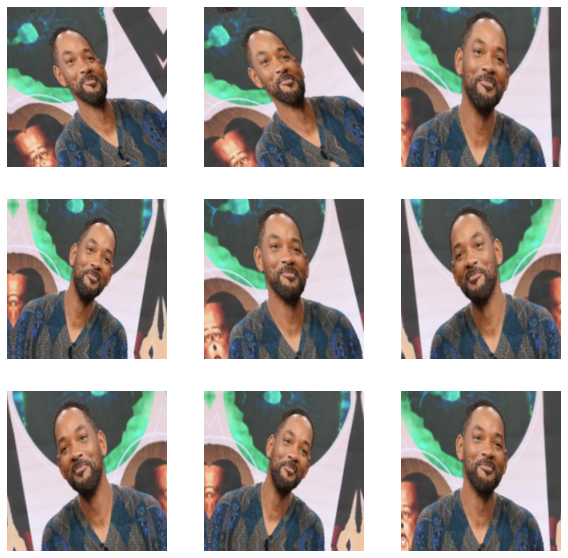

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/aah')

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


Mounted at /content/drive
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......rescaling
.........vars
......sequential
.........layers
............random_flip
...............vars
............random_rotation
...............vars
............random_zoom
...............vars
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-21 21:02:04           64
config.json                                    2

In [20]:
model.save('model')

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/15


9/9 [==============================] - 8s 280ms/step - loss: 0.9743 - accuracy: 0.4615 - val_loss: 0.6812 - val_accuracy: 0.6667
Epoch 2/15
9/9 [==============================] - 3s 390ms/step - loss: 0.6966 - accuracy: 0.5769 - val_loss: 0.6534 - val_accuracy: 0.6667
Epoch 3/15
9/9 [==============================] - 2s 228ms/step - loss: 0.6462 - accuracy: 0.6154 - val_loss: 0.7095 - val_accuracy: 0.5000
Epoch 4/15
9/9 [==============================] - 2s 226ms/step - loss: 0.5636 - accuracy: 0.6538 - val_loss: 0.6120 - val_accuracy: 0.5000
Epoch 5/15
9/9 [==============================] - 2s 219ms/step - loss: 0.3362 - accuracy: 0.9231 - val_loss: 1.4983 - val_accuracy: 0.5000
Epoch 6/15
9/9 [==============================] - 2s 266ms/step - loss: 0.2405 - accuracy: 0.9231 - val_loss: 1.1668 - val_accuracy: 0.6667
Epoch 7/15
9/9 [==============================] - 3s 355ms/step - loss: 0.1417 - accuracy: 0.9231 - val_loss: 1.6480 - val_accuracy: 0.6667
Epoch 8/15
9/9 [===============

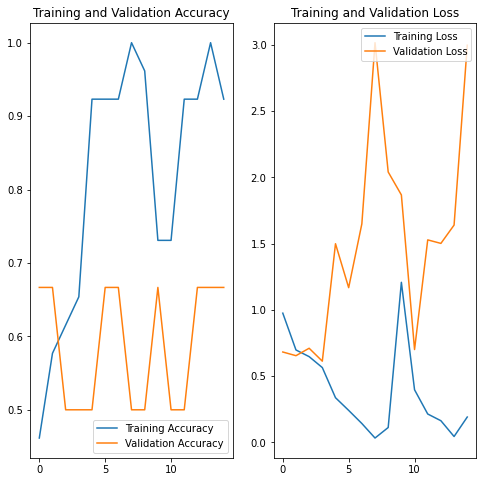

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

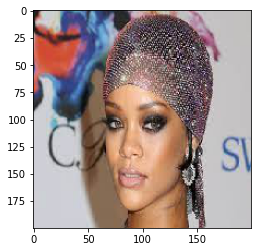

1/1 [==============================] - 0s 61ms/step
L'image appartient probablement à la classe 'rihanna' avec une confiance de 91.48 pourcent.


In [58]:
data = tf.keras.utils.get_file(
    "bb.zip",
    "https://github.com/kela2023/aah/blob/main/bb.zip/?raw=true",
    extract=False
)

import zipfile
with zipfile.ZipFile(data, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/bb')

img_path = data_dir / 'rihanna' / 'download (2).jfif'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))

img_array = tf.keras.preprocessing.image.img_to_array(img)

plt.imshow(img_array.astype(int))
plt.show()

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "L'image appartient probablement à la classe '{}' avec une confiance de {:.2f} pourcent."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
